# Deep Learning approach to the Titanic problem

In [1]:
%env PYTHONHASHSEED=0

import os
DEVMODE = os.getenv("KAGGLE_MODE") == "DEV"
print(f"DEV MODE: {DEVMODE}")

# Define seed to reprodicibility of random generation
SEED = 42
DEV_SPLIT = 0.2

env: PYTHONHASHSEED=0
DEV MODE: True


In [2]:
import importlib
if importlib.util.find_spec("comet_ml"):
    from comet_ml import Experiment
    experiment = Experiment(project_name="titanic")
else:
    experiment = None

COMET INFO: old comet version (3.1.9) detected. current: 3.1.12 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/witalia008/titanic/7f2250054c194eefa185739df1f13bda



In [3]:
import numpy as np
import pandas as pd

# To display all the columns from left to right without breaking into next line.
pd.set_option("display.width", 1500)
pd.plotting.register_matplotlib_converters()

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.2.0


In [ ]:
import random as python_random

# Make sure Keras produces reproducible results.

np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(physical_devices)
for device in (physical_devices or []):
    tf.config.experimental.set_memory_growth(device, True)

[]


## Load data and split into train/dev sets

In [7]:
from titanic.titanic_data import load_titanic_data, split_data, get_data_preprocessor

X_train_full, y_train_full, X_pred = load_titanic_data()
X_train, X_valid, y_train, y_valid = split_data(X_train_full, y_train_full, test_size=DEV_SPLIT, random_state=SEED)

## Define pre-processing of the data

In [8]:
preprocessor, preprocessed_column_names = get_data_preprocessor()

In [9]:
X_train = pd.DataFrame(preprocessor.fit_transform(X_train), index=X_train.index, columns=preprocessed_column_names)
X_valid = pd.DataFrame(preprocessor.transform(X_valid), index=X_valid.index, columns=preprocessed_column_names)
X_pred = pd.DataFrame(preprocessor.transform(X_pred), index=X_pred.index, columns=preprocessed_column_names)

In [10]:
X_train.head()

,Pclass,Female,Male,C,Q,S,Master,Miss,Mr,Mrs,Others,Fare,Family,Age_Missing,Age
PassengerId,,,,,,,,,,,,,,,
332,-1.614136,-0.724310,0.724310,-0.461462,-0.303355,0.592489,-0.220456,-0.501316,0.836232,-0.394771,-0.174329,0.437404,-0.554666,-0.494727,0.862119
734,-0.400551,-0.724310,0.724310,-0.461462,-0.303355,0.592489,-0.220456,-0.501316,0.836232,-0.394771,-0.174329,-0.322935,-0.554666,-0.494727,-0.435616
383,0.813034,-0.724310,0.724310,-0.461462,-0.303355,0.592489,-0.220456,-0.501316,0.836232,-0.394771,-0.174329,-0.782201,-0.554666,-0.494727,0.862119
705,0.813034,-0.724310,0.724310,-0.461462,-0.303355,0.592489,-0.220456,-0.501316,0.836232,-0.394771,-0.174329,-0.790325,0.040096,-0.494727,-0.435616
814,0.813034,1.380624,-1.380624,-0.461462,-0.303355,0.592489,-0.220456,1.994748,-1.195840,-0.394771,-0.174329,0.529116,3.013909,-0.494727,-1.733351


## DL model using Keras

In [11]:
METRICS = [
      keras.metrics.TruePositives(name="tp"),
      keras.metrics.FalsePositives(name="fp"),
      keras.metrics.TrueNegatives(name="tn"),
      keras.metrics.FalseNegatives(name="fn"),
      keras.metrics.BinaryAccuracy(name="accuracy"),
      keras.metrics.Precision(name="precision"),
      keras.metrics.Recall(name="recall"),
      keras.metrics.AUC(name="auc"),
]

def get_model(input_size):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        Dense(128, input_shape=(input_size,), activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer="he_uniform"),
        Dropout(0.2),
        Dense(32, activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer="he_uniform"),
        Dropout(0.2),
        Dense(20, activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer="he_uniform"),
        Dropout(0.25),
        Dense(6, activation="tanh", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer="glorot_uniform"),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3), metrics=METRICS, loss="binary_crossentropy")
    
    return model

In [12]:
died_cnt, survived_cnt = np.bincount(y_train)
total_cnt = died_cnt + survived_cnt

weight_died = total_cnt / died_cnt / 2
weight_survived = total_cnt / survived_cnt / 2

class_weights = {0: weight_died, 1: weight_survived}

In [13]:
# Create a new model each time before running training (otherwise new trainings would just be on already trained model)
model = get_model(X_train.shape[1])

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_valid, y_valid), class_weight=class_weights, verbose=0)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


## Results of the DL model

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


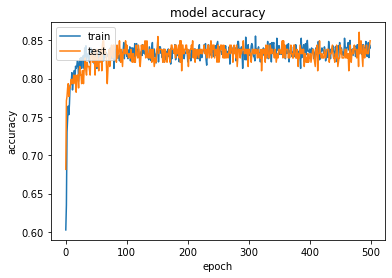

In [14]:
from utils.visualising import plot_model_history

plot_model_history(history)

Train evaluation:
23/23 - 0s - loss: 0.4411 - tp: 213.0000 - fp: 57.0000 - tn: 387.0000 - fn: 55.0000 - accuracy: 0.8427 - precision: 0.7889 - recall: 0.7948 - auc: 0.8897


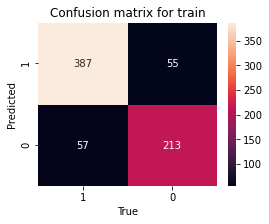

In [15]:
from utils.visualising import draw_confusion_matrix

print("Train evaluation:")
evaluation_train = model.evaluate(X_train, y_train, verbose=2)
draw_confusion_matrix(evaluation_train, "train")

Valid evaluation:
6/6 - 0s - loss: 0.4852 - tp: 62.0000 - fp: 15.0000 - tn: 90.0000 - fn: 12.0000 - accuracy: 0.8492 - precision: 0.8052 - recall: 0.8378 - auc: 0.9020


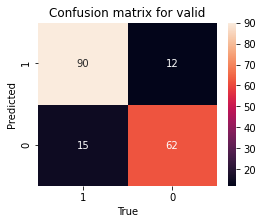

In [16]:
print("Valid evaluation:")
evaluation_valid = model.evaluate(X_valid, y_valid, verbose=2)
draw_confusion_matrix(evaluation_valid, "valid")

## Predict with DL model

In [17]:
from utils.predicting import store_predictions

In [18]:
store_predictions(model, X_pred=X_pred, index=X_pred.index, submission_name="dl")

dl:
[0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 1
 1 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0]...


In [ ]:
if experiment:
    experiment.end()